# Data Bases Project
## PHILIPPE Marie & SERRAZ Claire
## Due Date: 04/04/22
## M2 D3S TSE (Apprentices Track)

# 0. Prerequisite part

In [1]:
#-- Import different libraries needed for the analysis

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re 
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import stem, WordNetLemmatizer
nltk.download('stopwords')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/marie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/marie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Part 1: Creating and Populating the database

## 1.1. Creating the databse

In [2]:
#-- Create a database and its connection

database_name='DB_Project.db'
con = sqlite3.connect(database_name)
c=con.cursor()

### 1.1.1 Drop the tables

In [3]:
#-- Create a dictionary for the drops instructions in SQL

sql_drops = {'drop_author': '''DROP TABLE IF EXISTS author;''',
            'drop_distinguished': '''DROP TABLE IF EXISTS distinguished;''',
            'drop_controversy':'''DROP TABLE IF EXISTS controversy;''',
            'drop_removal':'''DROP TABLE IF EXISTS removal;''',
            'drop_score':'''DROP TABLE IF EXISTS score;''',
            'drop_parent':'''DROP TABLE IF EXISTS parent;''',
            'drop_subreddit':'''DROP TABLE IF EXISTS subreddit;''',
            'drop_comment':'''DROP TABLE IF EXISTS comment;''',
            'drop_is_distinguished':'''DROP TABLE IF EXISTS is_distinguished;''',
            'drop_removed': '''DROP TABLE IF EXISTS removed;''',
            'drop_depends':'''DROP TABLE IF EXISTS depends;'''}

In [4]:
#-- If needed, drop all the tables

for k in sql_drops:
    sql = sql_drops[k]
    c.execute(sql)

### 1.1.2 Create the tables

In [5]:
#-- Create a dictionary for the creates instricutions in SQL

sql_creates = {'create_author': '''CREATE TABLE author (author TEXT, CONSTRAINT pk_author PRIMARY KEY (author));''',
               
            'create_distinguished': '''CREATE TABLE distinguished (distinguished TEXT, CONSTRAINT pk_distinguished PRIMARY KEY (distinguished));''',
               
            'create_controversy':'''CREATE TABLE controversy (controversiality INT, CONSTRAINT pk_controversy PRIMARY KEY (controversiality));''',
               
            'create_removal':'''CREATE TABLE removal (removal_reason TEXT, CONSTRAINT pk_removal PRIMARY KEY (removal_reason));''',
               
            'create_score':'''CREATE TABLE score (id TEXT, score INT, ups INT, downs INT, score_hidden BIT, gilded INT, CONSTRAINT pk_score PRIMARY KEY (id), CONSTRAINT fk_score_comment FOREIGN KEY (id) REFERENCES comment (id));''',
               
            'create_parent':'''CREATE TABLE parent (parent_id TEXT, link_id INT, CONSTRAINT pk_parent PRIMARY KEY (parent_id));''',
               
            'create_subreddit':'''CREATE TABLE subreddit (subreddit_id TEXT, subreddit TEXT, CONSTRAINT pk_subreddit PRIMARY KEY (subreddit_id));''',
               
            'create_comment':'''CREATE TABLE comment (id TEXT, created_utc INT, name TEXT, body TEXT, edited INT, author_flair_css_class TEXT, author_flair_text TEXT, author TEXT, controversiality INT, subreddit_id INT, CONSTRAINT pk_comment PRIMARY KEY (id), CONSTRAINT fk_comment_author FOREIGN KEY (author) REFERENCES author (author), CONSTRAINT fk_comment_controversy FOREIGN KEY (controversiality) REFERENCES controversy (controversiality), CONSTRAINT fk_comment_subreddit FOREIGN KEY (subreddit_id) REFERENCES subreddit (subreddit_id));''',
               
            'create_is_distinguished':'''CREATE TABLE is_distinguished (id TEXT, distinguished TEXT, CONSTRAINT pk_is_distinguished PRIMARY KEY (id, distinguished), CONSTRAINT fk_id_comment FOREIGN KEY (id) REFERENCES comment (id), CONSTRAINT fk_id_distinguished FOREIGN KEY (distinguished) REFERENCES distinguished (distinguished));''',
               
            'create_removed': '''CREATE TABLE removed (id TEXT, removal_reason TEXT, CONSTRAINT pk_removed PRIMARY KEY (id, removal_reason), CONSTRAINT fk_removed_comment FOREIGN KEY (id) REFERENCES comment (id), CONSTRAINT fk_removed_removal FOREIGN KEY (removal_reason) REFERENCES distinguished (removal_reason));''',
               
            'create_depends':'''CREATE TABLE depends (id TEXT, parent_id TEXT, CONSTRAINT pk_depends PRIMARY KEY (id, parent_id), CONSTRAINT fk_depends_comment FOREIGN KEY (id) REFERENCES comment (id), CONSTRAINT fk_depends_parent FOREIGN KEY (parent_id) REFERENCES parent (parent_id));'''}

In [6]:
#-- Create all the tables

for k in sql_creates:
    sql = sql_creates[k]
    c.execute(sql)

### 1.1.3 Create the index

In [7]:
#-- Create a dictionary for the unique index instructions in SQL

sql_unique_index = {'ui_author': '''CREATE UNIQUE INDEX unique_index_author ON author (author);''',
            'ui_distinguished': '''CREATE UNIQUE INDEX unique_index_distinguished ON distinguished (distinguished);''',
            'ui_controversy':'''CREATE UNIQUE INDEX unique_index_controversy ON controversy (controversiality);''',
            'ui_removal':'''CREATE UNIQUE INDEX unique_index_removal ON removal (removal_reason);''',
            'ui_score':'''CREATE UNIQUE INDEX unique_index_score ON score (id);''',
            'ui_parent':'''CREATE UNIQUE INDEX unique_index_parent ON parent (parent_id);''',
            'ui_subreddit':'''CREATE UNIQUE INDEX unique_index_subreddit ON subreddit (subreddit_id);''',
            'ui_comment':'''CREATE UNIQUE INDEX unique_index_comment ON comment (id);''',
            'ui_is_distinguished':'''CREATE UNIQUE INDEX unique_index_is_distinguished ON is_distinguished (id, distinguished);''',
            'ui_removed': '''CREATE UNIQUE INDEX unique_index_removed ON removed (id, removal_reason);''',
            'ui_depends':'''CREATE UNIQUE INDEX unique_index_depends ON depends (id, parent_id);'''}

In [8]:
#-- Create all the unique index

for k in sql_unique_index:
    sql = sql_unique_index[k]
    c.execute(sql)

## 1.2. Loading the data into the database

### 1.2.1 Import the csv files

In [9]:
#-- Import the csv

#-- Claire
#path = 'C:/DESKTOP/DB - WB/csv_askreddit_2015_split_dataset/'

#-- Marie
path = '/Users/marie/Desktop/Cours/S2/Data bases/Data/'

table_author = pd.read_csv(path + 'exp_author.csv')
table_distinguished = pd.read_csv(path + 'exp_distinguihshed.csv')
table_controversy = pd.read_csv(path + 'exp_controverse.csv')
table_removal = pd.read_csv(path + 'exp_removal.csv')
table_score = pd.read_csv(path + 'exp_score.csv')
table_parent = pd.read_csv(path + 'exp_parent.csv')
table_subreddit = pd.read_csv(path + 'exp_subreddit.csv')
table_comment = pd.read_csv(path + 'exp_comment.csv')
table_is_distinguished = pd.read_csv(path + 'exp_askreddit_is_distinguihshed.csv')
table_depends = pd.read_csv(path + 'exp_askreddit_depends.csv')

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
#-- Print the size of each imported tables

print('The table author has', len(table_author), 'rows.')
print('The table distinguished has', len(table_distinguished), 'rows.')
print('The table controversy has', len(table_controversy), 'rows.')
print('The table removal has', len(table_removal), 'rows.')
print('The table score has', len(table_score), 'rows.')
print('The table parent has', len(table_parent), 'rows.')
print('The table subreddit has', len(table_subreddit), 'rows.')
print('The table comment has', len(table_comment), 'rows.')
print('The table is_distinguished has', len(table_is_distinguished), 'rows.')
print('The table depends has', len(table_depends), 'rows.')

The table author has 570735 rows.
The table distinguished has 2 rows.
The table controversy has 2 rows.
The table removal has 0 rows.
The table score has 4234970 rows.
The table parent has 1464558 rows.
The table subreddit has 1 rows.
The table comment has 4234970 rows.
The table is_distinguished has 4234970 rows.
The table depends has 4234970 rows.


One can see above that there are tables with 4234970 rows and others with less.

### 1.2.2 Populating the tables

In [11]:
#-- Transform dataframe rows into list

list_author = list(table_author.itertuples(index=False, name=None))
list_distinguished = list(table_distinguished.itertuples(index=False, name=None))
list_controversy = list(table_controversy.itertuples(index=False, name=None))
list_removal = list(table_removal.itertuples(index=False, name=None))
list_score = list(table_score.itertuples(index=False, name=None))
list_parent = list(table_parent.itertuples(index=False, name=None))
list_subreddit = list(table_subreddit.itertuples(index=False, name=None))
list_comment = list(table_comment.itertuples(index=False, name=None))
list_is_distinguished = list(table_is_distinguished.itertuples(index=False, name=None))
list_depends = list(table_depends.itertuples(index=False, name=None))


In [12]:
#-- Create a dictionary for the insert instructions in SQL

sql_insert = {'insert_author': '''INSERT INTO author (author) VALUES (?);''',
                   'insert_distinguished': '''INSERT INTO distinguished (distinguished) VALUES (?);''',
                   'insert_controversy': '''INSERT INTO controversy (controversiality) VALUES (?);''',
                   'insert_removal': '''INSERT INTO removal (removal_reason) VALUES (?);''',
                   'insert_score': '''INSERT INTO score (id, score, ups, downs, score_hidden, gilded) VALUES (?, ?, ?, ?, ?, ?);''',
                   'insert_parent': '''INSERT INTO parent (parent_id, link_id) VALUES (?, ?);''',
                   'insert_subreddit': '''INSERT INTO subreddit (subreddit_id, subreddit) VALUES (?, ?);''',
                   'insert_comment': '''INSERT INTO comment (id, created_utc, name, body, edited, author_flair_css_class, author_flair_text, author, controversiality, subreddit_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);''',
                   'insert_is_distinguished': '''INSERT INTO is_distinguished (id, distinguished) VALUES (?, ?);''',
                   'insert_removed': '''INSERT INTO removed (id, removal_reason) VALUES (?, ?);''',
                   'insert_depends': '''INSERT INTO depends (id, parent_id) VALUES (?, ?);'''}        

In [13]:
#-- Execute the sql_insert instructions previously stored into a dictionary

c.executemany(sql_insert['insert_author'], list_author)
c.executemany(sql_insert['insert_distinguished'], list_distinguished)
c.executemany(sql_insert['insert_controversy'], list_controversy)
c.executemany(sql_insert['insert_removal'], list_removal)
c.executemany(sql_insert['insert_score'], list_score)
c.executemany(sql_insert['insert_parent'], list_parent)
c.executemany(sql_insert['insert_subreddit'], list_subreddit)
c.executemany(sql_insert['insert_comment'], list_comment)
c.executemany(sql_insert['insert_is_distinguished'], list_is_distinguished)
c.executemany(sql_insert['insert_depends'], list_depends)

In [14]:
con.commit()

In [15]:
#-- Show how many rows per table

sql_count = {'count_author': '''SELECT * FROM author;''',
            'count_distinguished': '''SELECT * FROM distinguished;''',
            'count_controversy': '''SELECT * FROM controversy;''',
            'count_removal': '''SELECT * FROM removal;''',
            'count_score': '''SELECT * FROM score;''',
            'count_parent': '''SELECT * FROM parent;''',
            'count_subreddit': '''SELECT * FROM subreddit;''',
            'count_comment': '''SELECT * FROM comment;''',
            'count_is_distinguished': '''SELECT * FROM is_distinguished;''',
            'count_depends': '''SELECT * FROM depends;''',
            'count_removed': '''SELECT * FROM removed;'''}
n_rows={}

for k in sql_count:
    sql = sql_count[k]
    n_rows[k] = len(c.execute(sql).fetchall())

n_rows

{'count_author': 570735,
 'count_distinguished': 2,
 'count_controversy': 2,
 'count_removal': 0,
 'count_score': 4234970,
 'count_parent': 1464558,
 'count_subreddit': 1,
 'count_comment': 4234970,
 'count_is_distinguished': 4234970,
 'count_depends': 4234970,
 'count_removed': 0}

### 1.2.3 Computing the size of the tables

In [16]:
#-- Subselection of the data that would represent only about 5MB

#-- Count the number of page
c.execute('SELECT page_count FROM pragma_page_count();')
nb_page = c.fetchall()
print('There are', nb_page[0][0], 'pages in our database.')

#-- Compute the size of a page, in bytes
c.execute('SELECT page_size FROM pragma_page_size();')
size_page = c.fetchall()
print('A page "measures"', size_page[0][0],'bytes.')

#-- Compute the size of the whole database in bytes.
c.execute('SELECT page_count*page_size FROM pragma_page_count(), pragma_page_size();')
size_db = c.fetchall()
print('The whole database "measures"', size_db[0][0], 'bytes.')

#-- 1 Byte = 0.000001 MB

#-- Compute the size of the whole database in MB.
c.execute('SELECT (page_count*page_size) * 0.000001 FROM pragma_page_count(), pragma_page_size();')
size_db_MB = c.fetchall()
print('The whole database "measures"', round(size_db_MB[0][0], 4), 'MB.')

#-- Our dataset is way bigger than 5MB.

# Compute the number of pages needed to have a database of size 5MB.
c.execute('SELECT 5/0.000001/page_size FROM pragma_page_size();')
nb_pages_5MB = c.fetchall()
print('A sub database of size 5MB should have', round(nb_pages_5MB[0][0],4), 'pages.')

#-- Our database contains 4 234 970 rows.

#-- Compute the number of row in a page in our database.
c.execute('SELECT 4234970/page_count FROM pragma_page_count();')
page_row = c.fetchall()
print('There are', page_row[0][0], 'rows in a page in our database.')

#-- Compute the number of rows needed to have a database of size 5MB.
c.execute('SELECT (5/0.000001/page_size)*(4234970/page_count) FROM pragma_page_size(), pragma_page_count();')
nb_rows_5MB = c.fetchall()
print('A sub database of size 5MB should have', round(nb_rows_5MB[0][0],4), 'rows.')

There are 500330 pages in our database.
A page "measures" 4096 bytes.
The whole database "measures" 2049351680 bytes.
The whole database "measures" 2049.3517 MB.
A sub database of size 5MB should have 1220.7031 pages.
There are 8 rows in a page in our database.
A sub database of size 5MB should have 9765.625 rows.


In [17]:
#-- Creation of the new database

#-- 9765 rows have to be kept to have a database of size 5MB. 

### 1.2.4 Creating a subset of 5 MB

This step is done only once, which explains that the following code is put in comment

In [18]:
#-- If needed, drop all the new tables

#sql_drops2 = {'drop_comment2': '''DROP TABLE IF EXISTS comment2;''',
              #'drop_author2': '''DROP TABLE IF EXISTS author2;''',
              #'drop_score2': '''DROP TABLE IF EXISTS score2;''',
              #'drop_controversy2': '''DROP TABLE IF EXISTS controversy2;''',
              #'drop_depends2': '''DROP TABLE IF EXISTS depends2;''',
              #'drop_parent2': '''DROP TABLE IF EXISTS parent2;''',
              #'drop_is_distinguished2': '''DROP TABLE IF EXISTS is_distinguished2;''',
              #'drop_distinguished2': '''DROP TABLE IF EXISTS distinguished2;'''}

#-- Create a dictionary for the drops instructions in SQL

#for k in sql_drops2:
    #sql = sql_drops2[k]
    #c.execute(sql)

In [19]:
##-- Create the new tables

#sql_new_tables = {'new_comment': '''CREATE TABLE comment2 AS
                                    #SELECT * FROM comment ORDER BY random() LIMIT 1700;''', 
                 
                  #'new_author': '''CREATE TABLE author2 AS
                                    #SELECT * FROM author AS a
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM comment2 AS c
                                        #WHERE c.author = a.author);''',
                  
                  #'new_score': '''CREATE TABLE score2 AS
                                   # SELECT * FROM score AS s
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM comment2 AS c
                                        #WHERE c.id = s.id);''',
                  
                  #'new_controversy': '''CREATE TABLE controversy2 AS
                                    #SELECT * FROM controversy AS cont
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM comment2 AS c
                                        #WHERE c.controversiality = cont.controversiality);''',
                  
                  #'new_depends': '''CREATE TABLE depends2 AS
                                    #SELECT * FROM depends AS d
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM comment2 AS c
                                        #WHERE c.id = d.id);''',
                  
                  #'new_parent': '''CREATE TABLE parent2 AS
                                    #SELECT * FROM parent AS p
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM depends2 AS d
                                        #WHERE d.parent_id = p.parent_id);''',
                  
                  #'new_is_distinguished': '''CREATE TABLE is_distinguished2 AS
                                    #SELECT * FROM is_distinguished AS d
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM comment2 AS c
                                        #WHERE c.id = d.id);''', 
                 
                  #'new_distinguished': '''CREATE TABLE distinguished2 AS
                                    #SELECT * FROM distinguished AS d
                                    #WHERE EXISTS (
                                        #SELECT *
                                        #FROM is_distinguished2 AS d2
                                        #WHERE d2.distinguished = d.distinguished);'''}

#-- Create a dictionary for the create instructions in SQL
                                        
#for k in sql_new_tables:
    #sql = sql_new_tables[k]
    #c.execute(sql)

In [20]:
#-- Show how many rows per table

#sql_count2 = {'count_author': '''SELECT * FROM author2;''',
            #'count_distinguished': '''SELECT * FROM distinguished2;''',
            #'count_controversy': '''SELECT * FROM controversy2;''',
            #'count_score': '''SELECT * FROM score2;''',
            #'count_parent': '''SELECT * FROM parent2;''',
            #'count_comment': '''SELECT * FROM comment2;''',
            #'count_is_distinguished': '''SELECT * FROM is_distinguished2;''',
            #'count_depends': '''SELECT * FROM depends2;'''}
#n_rows={}

#for k in sql_count2:
    #sql = sql_count2[k]
    #n_rows[k] = len(c.execute(sql).fetchall())

#n_rows

In [21]:
#-- Create pandas dataframes from the tables 

#comment2 = pd.read_sql('''SELECT * FROM comment2;''', con)
#author2 = pd.read_sql('''SELECT * FROM author2;''', con)
#score2 = pd.read_sql('''SELECT * FROM score2;''', con)
#controversy2 = pd.read_sql('''SELECT * FROM controversy2;''', con)
#depends2 = pd.read_sql('''SELECT * FROM depends2;''', con)
#parent2 = pd.read_sql('''SELECT * FROM parent2;''', con)
#is_distinguished2 = pd.read_sql('''SELECT * FROM is_distinguished2;''', con)
#distinguished2 = pd.read_sql('''SELECT * FROM distinguished2;''', con)

In [22]:
#-- Extract the new files as csv 

#-- Claire
#path = 'C:/DESKTOP/DB - WB/csv_askreddit_2015_split_dataset/'

#-- Marie
#path = '/Users/marie/Desktop/Cours/S2/Data bases/Data/New/'

#comment2.to_csv(path + 'comment.csv', index = False)
#author2.to_csv(path + 'author.csv', index = False)
#score2.to_csv(path + 'score.csv', index = False)
#controversy2.to_csv(path + 'controversy.csv', index = False)
#depends2.to_csv(path + 'depends.csv', index = False)
#parent2.to_csv(path + 'parent.csv', index = False)
#is_distinguished2.to_csv(path + 'is_distinguished.csv', index = False)
#distinguished2.to_csv(path + 'distinguished.csv', index = False)

# 2. Part 2: Exploring the database using SQL

## New database import

In [23]:
#-- Create a database and its connection

database_name='DB_Project2.db'
con = sqlite3.connect(database_name)
c = con.cursor()

In [24]:
#-- Create a dictionary for the drops instructions in SQL

sql_drops2 = {'drop_author': '''DROP TABLE IF EXISTS author;''',
            'drop_distinguished': '''DROP TABLE IF EXISTS distinguished;''',
            'drop_controversy':'''DROP TABLE IF EXISTS controversy;''',
            'drop_removal':'''DROP TABLE IF EXISTS removal;''',
            'drop_score':'''DROP TABLE IF EXISTS score;''',
            'drop_parent':'''DROP TABLE IF EXISTS parent;''',
            'drop_subreddit':'''DROP TABLE IF EXISTS subreddit;''',
            'drop_comment':'''DROP TABLE IF EXISTS comment''',
            'drop_is_distinguished':'''DROP TABLE IF EXISTS is_distinguished;''',
            'drop_removed': '''DROP TABLE IF EXISTS removed;''',
            'drop_depends':'''DROP TABLE IF EXISTS depends;''',
            'drop_word':'''DROP TABLE IF EXISTS word;'''}

#-- If needed, drop all the tables

for k in sql_drops2:
    sql = sql_drops2[k]
    c.execute(sql)

In [25]:
#-- Create a dictionary for the creates instricutions in SQL

sql_creates2 = {'create_author': '''CREATE TABLE author (author TEXT, CONSTRAINT pk_author PRIMARY KEY (author));''',
               
            'create_distinguished': '''CREATE TABLE distinguished (distinguished TEXT, CONSTRAINT pk_distinguished PRIMARY KEY (distinguished));''',
               
            'create_controversy':'''CREATE TABLE controversy (controversiality INT, CONSTRAINT pk_controversy PRIMARY KEY (controversiality));''',
               
            'create_score': '''CREATE TABLE score (id TEXT, score INT, ups INT, downs INT, score_hidden BIT, gilded INT, CONSTRAINT pk_score PRIMARY KEY (id), CONSTRAINT fk_score_comment FOREIGN KEY (id) REFERENCES comment (id));''',
               
            'create_parent':'''CREATE TABLE parent (parent_id TEXT, link_id INT, CONSTRAINT pk_parent PRIMARY KEY (parent_id));''',
               
            'create_comment':'''CREATE TABLE comment (id TEXT, created_utc INT, name TEXT, body TEXT, edited INT, author_flair_css_class TEXT, author_flair_text TEXT, author TEXT, controversiality INT, subreddit_id INT, CONSTRAINT pk_comment PRIMARY KEY (id), CONSTRAINT fk_comment_author FOREIGN KEY (author) REFERENCES author (author), CONSTRAINT fk_comment_controversy FOREIGN KEY (controversiality) REFERENCES controversy (controversiality), CONSTRAINT fk_comment_subreddit FOREIGN KEY (subreddit_id) REFERENCES subreddit (subreddit_id));''',
               
            'create_is_distinguished':'''CREATE TABLE is_distinguished (id TEXT, distinguished TEXT, CONSTRAINT pk_is_distinguished PRIMARY KEY (id, distinguished), CONSTRAINT fk_id_comment FOREIGN KEY (id) REFERENCES comment (id), CONSTRAINT fk_id_distinguished FOREIGN KEY (distinguished) REFERENCES distinguished (distinguished));''',
               
            'create_depends':'''CREATE TABLE depends (id TEXT, parent_id TEXT, CONSTRAINT pk_depends PRIMARY KEY (id, parent_id), CONSTRAINT fk_depends_comment FOREIGN KEY (id) REFERENCES comment (id), CONSTRAINT fk_depends_parent FOREIGN KEY (parent_id) REFERENCES parent (parent_id));'''}

#-- Create all the tables

for k in sql_creates2:
    sql = sql_creates2[k]
    c.execute(sql)

In [26]:
#-- Import the csv

#-- Claire
#path = 'C:/DESKTOP/DB - WB/csv_askreddit_2015_split_dataset/'

#-- Marie
path = '/Users/marie/Desktop/Cours/S2/Data bases/Data/New/'

table_author = pd.read_csv(path + 'author.csv')
table_distinguished = pd.read_csv(path + 'distinguished.csv')
table_controversy = pd.read_csv(path + 'controversy.csv')
table_score = pd.read_csv(path + 'score.csv')
table_parent = pd.read_csv(path + 'parent.csv')
table_comment = pd.read_csv(path + 'comment.csv')
table_is_distinguished = pd.read_csv(path + 'is_distinguished.csv')
table_depends = pd.read_csv(path + 'depends.csv')

In [27]:
#-- Transform dataframe rows into list

list_author = list(table_author.itertuples(index=False, name=None))
list_distinguished = list(table_distinguished.itertuples(index=False, name=None))
list_controversy = list(table_controversy.itertuples(index=False, name=None))
list_score = list(table_score.itertuples(index=False, name=None))
list_parent = list(table_parent.itertuples(index=False, name=None))
list_comment = list(table_comment.itertuples(index=False, name=None))
list_is_distinguished = list(table_is_distinguished.itertuples(index=False, name=None))
list_depends = list(table_depends.itertuples(index=False, name=None))

In [28]:
#-- Create a dictionary for the insert instructions in SQL

sql_insert = {'insert_author': '''INSERT INTO author (author) VALUES (?);''',
                   'insert_distinguished': '''INSERT INTO distinguished (distinguished) VALUES (?);''',
                   'insert_controversy': '''INSERT INTO controversy (controversiality) VALUES (?);''',
                   'insert_score': '''INSERT INTO score (id, score, ups, downs, score_hidden, gilded) VALUES (?, ?, ?, ?, ?, ?);''',
                   'insert_parent': '''INSERT INTO parent (parent_id, link_id) VALUES (?, ?);''',
                   'insert_comment': '''INSERT INTO comment (id, created_utc, name, body, edited, author_flair_css_class, author_flair_text, author, controversiality, subreddit_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);''',
                   'insert_is_distinguished': '''INSERT INTO is_distinguished (id, distinguished) VALUES (?, ?);''',
                   'insert_depends': '''INSERT INTO depends (id, parent_id) VALUES (?, ?);'''}        

In [29]:
#-- Execute the sql_insert instructions previously stored into a dictionary

c.executemany(sql_insert['insert_author'], list_author)
c.executemany(sql_insert['insert_distinguished'], list_distinguished)
c.executemany(sql_insert['insert_controversy'], list_controversy)
c.executemany(sql_insert['insert_score'], list_score)
c.executemany(sql_insert['insert_parent'], list_parent)
c.executemany(sql_insert['insert_comment'], list_comment)
c.executemany(sql_insert['insert_is_distinguished'], list_is_distinguished)
c.executemany(sql_insert['insert_depends'], list_depends)

## 2.1 Basic queries

### 2.1.1 Number of rows in each table 

In [30]:
#-- Count the number of rows in each table

sql_count3 = {'count_author': '''SELECT * FROM author;''',
            'count_distinguished': '''SELECT * FROM distinguished;''',
            'count_controversy': '''SELECT * FROM controversy;''',
            'count_score': '''SELECT * FROM score;''',
            'count_parent': '''SELECT * FROM parent;''',
            'count_comment': '''SELECT * FROM comment;''',
            'count_is_distinguished': '''SELECT * FROM is_distinguished;''',
            'count_depends': '''SELECT * FROM depends;'''}
n_rows3={}
sum_rows=0

for k in sql_count3:
    sql = sql_count3[k]
    n_rows3[k] = len(c.execute(sql).fetchall())
    sum_rows = sum_rows + n_rows3[k]

n_rows3

{'count_author': 1517,
 'count_distinguished': 1,
 'count_controversy': 2,
 'count_score': 1700,
 'count_parent': 1618,
 'count_comment': 1701,
 'count_is_distinguished': 1700,
 'count_depends': 1700}

In [31]:
#-- Total number of rows 

print('Total number of rows:', sum_rows)

Total number of rows: 9939


### 2.1.2 Author statistics

In [32]:
#-- Have an overall view of the author table

pd.read_sql('''SELECT * FROM author;''', con)

,author
0,-_-Edit_Deleted-_-
1,-_-Equinox666-_-
2,07hogada
3,10-10withrice
4,1337ish
...,...
1512,zachwad22
1513,zaprowsdower13
1514,zigglezip
1515,zw1ck


In [33]:
#-- Minimum, maximum and average number of comments written by the same author

query_authors_1 = '''SELECT min(countcomment) AS "Minimum number of comments by author", 
                         max(countcomment) AS "Maximum number of comments by author",
                         round(avg(countcomment),3) AS "Average number of comment by author"
                         FROM (SELECT c.author, COUNT(c.id) AS "countcomment"
                         FROM comment AS c
                         GROUP BY c.author);'''

df_authors_1 = pd.read_sql(query_authors_1, con)
df_authors_1

,Minimum number of comments by author,Maximum number of comments by author,Average number of comment by author
0,1,127,1.121


In [34]:
#-- Number of authors that have written more than 1 comment 

query_authors_2 = '''SELECT c.author, COUNT(c.id) AS "number of comments"
                        FROM comment AS c
                        GROUP BY c.author
                        HAVING COUNT(c.id) > 1
                        ORDER BY count(c.id) DESC;'''

df_authors_2 = pd.read_sql(query_authors_2, con)
df_authors_2

,author,number of comments
0,[deleted],127
1,AutoModerator,18
2,Late_Night_Grumbler,7
3,-_-Equinox666-_-,5
4,suddenweightloss,3
5,roguetroll,3
6,bolognahole,3
7,walkingcarpet23,2
8,tinyhousebuilder,2
9,rotten_person,2


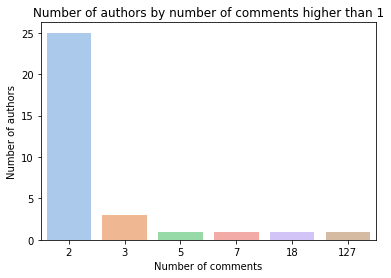

In [35]:
#-- Number of comments by author having written more than one comment - Graphical representation

sns.countplot(data = df_authors_2, x = "number of comments", 
              palette = "pastel").set(xlabel = "Number of comments", 
                                      ylabel = "Number of authors")
plt.title("Number of authors by number of comments higher than 1")
plt.show()

### 2.1.3 Comment statistics

In [36]:
#-- Have an overall view of the author table

pd.read_sql('''SELECT * FROM comment;''', con)

,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text,author,controversiality,subreddit_id
0,cr7tnws,1431531575,t1_cr7tnws,Energy Drinks! Energy drinks (including 5 hour...,0,None,None,morgantheron,0.0,t5_2qh1i
1,cr06tqw,1430919654,t1_cr06tqw,Furby.,0,None,None,pretendsnothere,0.0,t5_2qh1i
2,cqxowzn,1430716230,t1_cqxowzn,Butt cheek. Just as friends doe.,0,None,None,RandomestDragon,0.0,t5_2qh1i
3,cr40pzv,1431214861,t1_cr40pzv,My mom died yesterday ):,0,None,None,OzzyDaGrouch,0.0,t5_2qh1i
4,cr9dubp,1431642421,t1_cr9dubp,"I really hate that ""real women"" movement. A f...",0,None,None,MagicallyMalicious,0.0,t5_2qh1i
...,...,...,...,...,...,...,...,...,...,...
1696,cr0fqqk,1430934263,t1_cr0fqqk,cats,0,None,None,culz,0.0,t5_2qh1i
1697,cqzfj9a,1430855689,t1_cqzfj9a,"That's exactly how I sleep, and it kinks my ne...",0,None,None,TheLaramieReject,0.0,t5_2qh1i
1698,crnumw5,1432834260,t1_crnumw5,I like this quote from Douglas Adams' Dirk Gen...,0,None,None,plarah,0.0,t5_2qh1i
1699,crczv1m,1431962366,t1_crczv1m,I'm not especially that great at it. I do a li...,0,None,None,LearningLifeAsIGo,0.0,t5_2qh1i


In [37]:
#-- First and last comments date 

query_comment_1 = '''SELECT min(datetime(c.created_utc, 'unixepoch')) AS "Date first comment", 
                           max(datetime(c.created_utc, 'unixepoch')) AS "Date last comment"
                           FROM comment AS c;'''

df_comment_1 = pd.read_sql(query_comment_1, con)
df_comment_1

,Date first comment,Date last comment
0,1970-01-01 00:00:00,2015-05-31 23:47:53


In [38]:
#-- Delete the comment from 1970, which is actually a missing values

c.execute('''DELETE FROM comment AS c
                WHERE strftime('%m', datetime(c.created_utc, 'unixepoch')) = "01";''')

In [39]:
#-- First and last comments date 

query_comment_1bis = '''SELECT min(datetime(c.created_utc, 'unixepoch')) AS "Date first comment", 
                           max(datetime(c.created_utc, 'unixepoch')) AS "Date last comment"
                           FROM comment AS c;'''

df_comment_1bis = pd.read_sql(query_comment_1bis, con)
df_comment_1bis

,Date first comment,Date last comment
0,2015-05-01 00:02:28,2015-05-31 23:47:53


In [40]:
#-- Month with the number of comments

query_comment_2 = '''SELECT strftime('%m', datetime(c.created_utc, 'unixepoch')) AS "Month", 
                            count(c.id) as "Number of comments"
                            FROM comment AS c
                            GROUP BY strftime('%m', datetime(c.created_utc, 'unixepoch'));'''

df_comment_2 = pd.read_sql(query_comment_2, con)
df_comment_2

,Month,Number of comments
0,05,1700


In [41]:
#-- Minimum, maximum and average number of comments by day

query_comment_3 = '''SELECT min(countcomment) AS "Minimum number of comments", 
                            max(countcomment) AS "Maximum number of comments",
                            avg(countcomment) AS "Average number of comments"
                            FROM (SELECT strftime('%d', datetime(c.created_utc, 'unixepoch')) AS "Day", 
                                         count(c.id) AS "countcomment"
                                         FROM comment AS c
                                         GROUP BY strftime('%d', datetime(c.created_utc, 'unixepoch'))
                                         ORDER BY count(c.id) DESC);'''

df_comment_3 = pd.read_sql(query_comment_3, con)
df_comment_3

,Minimum number of comments,Maximum number of comments,Average number of comments
0,32,89,54.83871


In [42]:
#-- Day with the most number of comments

query_comment_4 = '''SELECT strftime('%d', datetime(c.created_utc, 'unixepoch')) AS "Day", 
                            count(c.id) AS "Number of comments"
                            FROM comment AS c
                            GROUP BY strftime('%d', datetime(c.created_utc, 'unixepoch'))
                            ORDER BY count(c.id) DESC;'''

df_comment_4 = pd.read_sql(query_comment_4, con)
df_comment_4

,Day,Number of comments
0,06,89
1,28,84
2,29,83
3,22,64
4,26,63
5,15,63
6,01,63
7,12,62
8,13,59
9,11,58


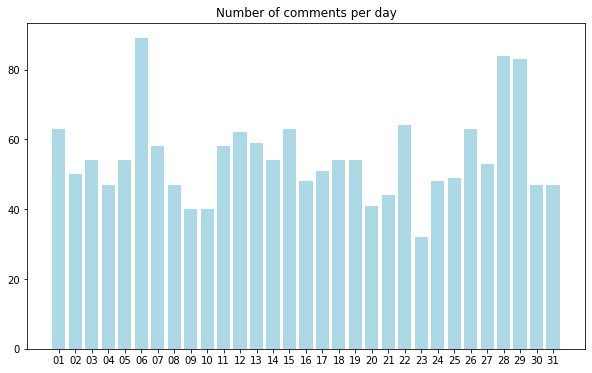

In [43]:
#-- Number of comments each day - Graphical representation

df_comment_5 = df_comment_4.sort_values(by="Day")

plt.figure(figsize=(10, 6))
plt.bar(x = "Day", data = df_comment_5, height = "Number of comments", 
        color = "lightblue")
plt.title("Number of comments per day")
plt.show()

In [44]:
#-- Associate weekday to day number

# Monday : 4, 11, 18, 25
# Tuesday : 5, 12, 19, 26
# Wednesday : 6, 13, 20, 27
# Thursday : 7, 14, 21, 28
# Friday : 1, 8, 15, 22, 29
# Saturday : 2, 9, 16, 23, 30
# Sunday : 3, 10, 17, 24, 31

weekdays = [('monday', '("04", "11", "18", "25")'), 
            ('tuesday', '("05", "12", "19", "26")'), 
            ('wednesday', '("06", "13", "20", "27")'),
            ('thursday', '("07", "14", "21", "28")'), 
            ('friday', '("01", "08", "15", "22", "29")'), 
            ('saturday', '("02", "09", "16", "23", "30")'), 
            ('sunday', '("03", "10", "17", "24", "31")')]

In [45]:
#-- Number of comments for each weekday

query_comment_6 = '''SELECT count(c.id) AS "Number of comments"
                        FROM comment AS c
                        WHERE strftime('%d',datetime(c.created_utc, 'unixepoch')) IN {};'''

df_comment_6 = pd.DataFrame([], columns=['Weekday', 'Number of comments'])

for i in range(len(weekdays)):
    df_comment_6 = df_comment_6.append( {'Weekday': weekdays[i][0], 
           'Number of comments': pd.read_sql(query_comment_6.format(weekdays[i][1]), 
                                             con)['Number of comments'][0]}, ignore_index=True)

df_comment_6

,Weekday,Number of comments
0,monday,208
1,tuesday,233
2,wednesday,242
3,thursday,240
4,friday,320
5,saturday,217
6,sunday,240


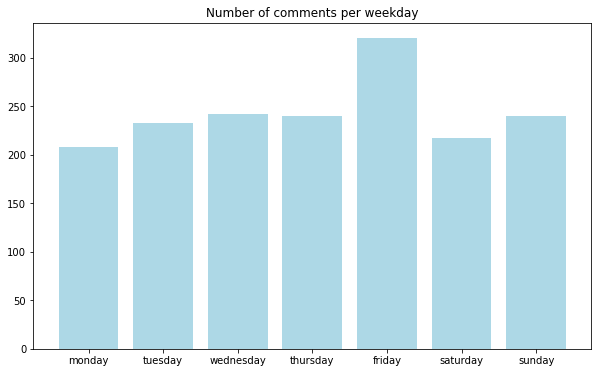

In [46]:
#-- Number of comments weekday - Graphical representation

plt.figure(figsize=(10, 6))
plt.bar(x = "Weekday", data = df_comment_6, height = "Number of comments", 
        color = "lightblue")
plt.title("Number of comments per weekday")
plt.show()

### 2.1.4 Parent statistics

In [47]:
#-- Have an overall view of the parent table

pd.read_sql('''SELECT * FROM parent;''', con)

,parent_id,link_id
0,t1_coc0ens,t3_2uv9wz
1,t1_cq7tz1a,t3_321meu
2,t1_cqoj1vg,t3_33t4q6
3,t1_cqs7iuz,t3_3489jw
4,t1_cqu0tun,t3_34aqsn
...,...,...
1613,t3_37z2hm,t3_37z2hm
1614,t3_37zcde,t3_37zcde
1615,t3_37zj03,t3_37zj03
1616,t3_37zl81,t3_37zl81


In [48]:
#-- Minimum, maximum and average number of replies

query_parent_1 = '''SELECT min(countcomment) AS "Minimum number of replies", 
                           max(countcomment) AS "Maximum number of replies",
                           round(avg(countcomment),3) AS "Average number of replies"
                        FROM (SELECT p.parent_id, COUNT(p.link_id) AS "countcomment"
                        FROM parent AS p
                        GROUP BY p.link_id);'''

df_parent_1 = pd.read_sql(query_parent_1, con)
df_parent_1

,Minimum number of replies,Maximum number of replies,Average number of replies
0,1,15,1.479


In [49]:
#-- Number of comments that have more than one reply

query_parent_2 = '''SELECT p.parent_id, count(p.link_id) AS "number of comments"
                FROM parent AS p
                GROUP BY p.link_id
                HAVING count(p.link_id) > 1
                ORDER BY count(p.link_id) DESC;'''

df_parent_2 = pd.read_sql(query_parent_2, con)
df_parent_2

,parent_id,number of comments
0,t1_crldt2w,15
1,t1_cron9zg,12
2,t1_crbbksr,12
3,t1_cr010xc,11
4,t1_cqzqzhn,11
...,...,...
201,t1_cqvdxim,2
202,t1_cquy01t,2
203,t1_cqujdr6,2
204,t1_cqv0roj,2


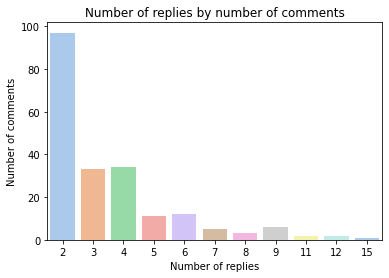

In [50]:
#-- Number of replies - Graphical representation

sns.countplot(data = df_parent_2, x = "number of comments", 
              palette = "pastel").set(xlabel = "Number of replies", 
                                      ylabel = "Number of comments")
plt.title("Number of replies by number of comments")
plt.show()

In [51]:
#-- Top 10 number of replies

query_parent_3 = '''SELECT p.parent_id, COUNT(p.link_id) AS "Number of replies"
                FROM parent AS p
                GROUP BY p.link_id
                ORDER BY COUNT(p.link_id) DESC
                LIMIT 10;'''

df_parent_3 = pd.read_sql(query_parent_3, con)
df_parent_3

,parent_id,Number of replies
0,t1_crldt2w,15
1,t1_cron9zg,12
2,t1_crbbksr,12
3,t1_cr010xc,11
4,t1_cqzqzhn,11
5,t1_crh3vze,9
6,t1_crfvpep,9
7,t1_crazy6o,9
8,t1_cr7pha2,9
9,t1_cr6ej2j,9


### 2.1.5 Score statistics

In [52]:
#-- Have an overall few of the score

pd.read_sql('''SELECT * FROM score AS s;''', con)

,id,score,ups,downs,score_hidden,gilded
0,cqugc1c,3,3,0,0,0
1,cquglv5,1,1,0,0,0
2,cqugyzu,1,1,0,0,0
3,cquh062,824,824,0,0,0
4,cquh363,-1,-1,0,0,0
...,...,...,...,...,...,...
1695,crr36yd,13,13,0,0,0
1696,crr3f6f,1,1,0,0,0
1697,crr66qk,1,1,0,0,0
1698,crr8p6t,1,1,0,0,0


In [53]:
#-- Mininum, maximum and average score

query_score_1 = '''SELECT avg(s.score) AS "Average score",
                          min(s.score) AS "Minimum score", 
                          max(s.score) AS "Maximum score"
                          FROM score AS s;'''

df_score_1 = pd.read_sql(query_score_1, con)
df_score_1

,Average score,Minimum score,Maximum score
0,21.902353,-83,4466


In [54]:
#-- 10 worst scores

query_score_2 = '''SELECT s.id, s.score
                        FROM score AS s
                        ORDER BY s.score 
                        LIMIT 10;'''

df_score_2 = pd.read_sql(query_score_2, con)
df_score_2

,id,score
0,crklhcv,-83
1,crktr4q,-34
2,crig3sx,-15
3,cquq9j5,-13
4,cr759o9,-9
5,cr0xhf4,-8
6,cqzyqni,-7
7,crcylp1,-7
8,crbufl1,-6
9,cqvbjbs,-5


In [55]:
#-- 10 best scores

query_score_3 = '''SELECT s.id, s.score
                        FROM score AS s
                        ORDER BY s.score DESC
                        LIMIT 10;'''

df_score_3 = pd.read_sql(query_score_3, con)
df_score_3

,id,score
0,cr4y7m7,4466
1,cr8phcb,4397
2,crmp2cq,3305
3,cr01luo,1713
4,crl1czr,1413
5,cqvt1ir,1278
6,cr5e1zm,1260
7,cqxddni,1197
8,cqy894x,1184
9,crfc940,1155


In [56]:
#-- Number of negative scores

query_score_4 = '''SELECT COUNT(neg.nbscore) AS "Number of negative scores"
                        FROM (SELECT s.id AS nbscore
                        FROM score AS s
                        WHERE s.score < 0) AS neg;'''

df_score_4 = pd.read_sql(query_score_4, con)
df_score_4

,Number of negative scores
0,43


In [57]:
#-- Number of scores equal to 0

query_score_5 = '''SELECT COUNT(zero.nbscore) AS "Number of scores equal to 0"
                FROM (SELECT s.id AS nbscore
                FROM score AS s
                WHERE s.score = 0) AS zero;'''

df_score_5 = pd.read_sql(query_score_5, con)
df_score_5

,Number of scores equal to 0
0,83


In [58]:
#-- Number of positive scores

query_score_6 = '''SELECT COUNT(pos.nbscore) AS "Number of positive scores"
                FROM (SELECT s.id AS nbscore
                FROM score AS s
                WHERE s.score > 0) AS pos;'''

df_score_6 = pd.read_sql(query_score_6, con)
df_score_6

,Number of positive scores
0,1574


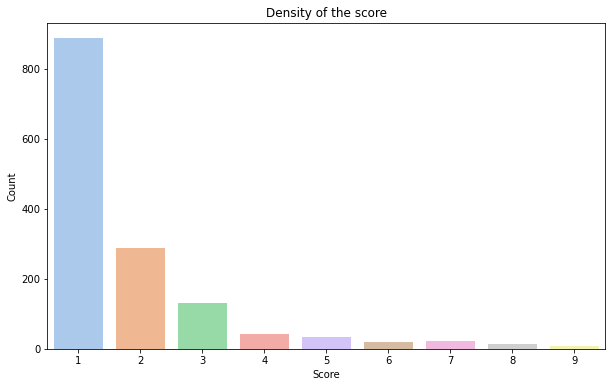

In [59]:
#-- Score distribution - Graphical representation

query_score_7 = '''SELECT s.score FROM score AS s 
                        WHERE s.score > 0 AND s.score < 10;'''

df_score_7 = pd.read_sql(query_score_7, con)

plt.figure(figsize=(10, 6))
sns.countplot(df_score_7['score'], palette = "pastel").set(xlabel = "Score", 
                                      ylabel = "Count")
plt.title("Density of the score")
plt.show()

## 2.2. More complex queries

### 2.2.1. Giving statistics about about the scores according to the fact that a comment is deleted or not

In [60]:
#-- Statistics on comments not deleted

query_notdeleted ='''SELECT CAST(pos.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments not deleted with a positive score", 
                            pos.AvgScore AS "Average Score among the positive scores",
                            CAST(neg.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments not deleted with a negative score", 
                            neg.AvgScore AS "Average Score among the negative scores",
                            CAST(zero.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments not deleted with a null score", 
                            ROUND(AVG(overall.AvgScore),2) AS "Overall Average Score for the comments not deleted",
                            overall.NbCom AS "Number of comments not deleted"

                            FROM (SELECT COUNT(c.body) AS "NbCom", 
                                         ROUND(AVG(s.score),2) AS "AvgScore"
                                         FROM comment AS c, score AS s 
                                         WHERE c.id = s.id  
                                             AND c.body NOT LIKE '%[deleted]%') AS overall,
                                             
                                 (SELECT COUNT(c.body) AS "NbCom", 
                                         ROUND(AVG(s.score),2) AS "AvgScore"
                                         FROM comment AS c, score AS s 
                                         WHERE c.id = s.id AND s.score>0 
                                             AND c.body NOT LIKE '%[deleted]%') AS pos,
                                             
                                 (SELECT COUNT(c.body) AS "NbCom", 
                                         ROUND(AVG(s.score),2) AS "AvgScore"
                                         FROM comment AS c, score AS s 
                                         WHERE c.id = s.id 
                                             AND s.score<0 
                                             AND c.body NOT LIKE '%[deleted]%') AS neg,
                                             
                                 (SELECT COUNT(c.body) AS "NbCom"
                                         FROM comment AS c, score AS s 
                                         WHERE c.id = s.id 
                                             AND s.score=0 
                                             AND c.body NOT LIKE '%[deleted]%') AS zero;'''

df_notdeleted = pd.read_sql(query_notdeleted, con)
df_notdeleted

,Percentage of Comments not deleted with a positive score,Average Score among the positive scores,Percentage of Comments not deleted with a negative score,Average Score among the negative scores,Percentage of Comments not deleted with a null score,Overall Average Score for the comments not deleted,Number of comments not deleted
0,92.618297,25.32,2.523659,-6.05,4.858044,23.3,1585


In [61]:
#-- Statistics on comments deleted

query_deleted ='''SELECT CAST(pos.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments deleted with a positive score", 
                         pos.AvgScore AS "Average Score among the positive scores",
                         CAST(neg.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments deleted with a negative score", 
                         neg.AvgScore AS "Average Score among the negative scores",
                         CAST(zero.NbCom AS float)/ CAST(overall.NbCom AS float)*100 AS "Percentage of Comments deleted with a null score", 
                         ROUND(AVG(overall.AvgScore),2) AS "Overall Average Score for the comments deleted",
                         overall.NbCom AS "Number of comments deleted"
                         
                         FROM   (SELECT COUNT(c.body) AS "NbCom", ROUND(AVG(s.score),2) AS "AvgScore"
                                    FROM comment AS c, score AS s 
                                    WHERE c.id = s.id  AND c.body LIKE '%[deleted]%') AS overall,
                            
                                (SELECT COUNT(c.body) AS "NbCom", ROUND(AVG(s.score),2) AS "AvgScore"
                                    FROM comment AS c, score AS s 
                                    WHERE c.id = s.id AND s.score>0 AND c.body LIKE '%[deleted]%') AS pos,
                                    
                                (SELECT COUNT(c.body) AS "NbCom", ROUND(AVG(s.score),2) AS "AvgScore"
                                    FROM comment AS c, score AS s 
                                    WHERE c.id = s.id AND s.score<0 AND c.body LIKE '%[deleted]%') AS neg,
                                
                                (SELECT COUNT(c.body) AS "NbCom"
                                    FROM comment AS c, score AS s 
                                    WHERE c.id = s.id AND s.score=0 AND c.body LIKE '%[deleted]%') AS zero;'''

df_deleted = pd.read_sql(query_deleted, con)
df_deleted

,Percentage of Comments deleted with a positive score,Average Score among the positive scores,Percentage of Comments deleted with a negative score,Average Score among the negative scores,Percentage of Comments deleted with a null score,Overall Average Score for the comments deleted,Number of comments deleted
0,92.173913,2.94,2.608696,-3.0,5.217391,2.63,115


This analysis allows to compare the deleted comments with the non deleted comments. It allows to suggest why some comments have been deleted. 
One can see that the percentage of comments with a positive score is similar for the deleted comments and for the not deleted comments. Similarly, the percentage of comments with a negative score is similar for the deleted comments and for the not deleted comments. Finally, the percentage of comments with a null score is similar for the deleted comments and for the not deleted comments. Thus, even if there are much more not deleted comments than deleted comments, the proportions of comments according to the sign of the scores remains quite similar from one group to another.

However, one can see that the average score is much more higher for the not deleted comments than for the deleted comments. As a comment cannot be scored after having been deleted, it means that they had this low score before being deleted, and that even may the reason why these comments were deleted.



### 2.2.2. Giving statistics about the scores according to the edition of the comments

In [62]:
#-- Statistics on the comments according to the edition or not

query_edition = '''SELECT   Ed.NbCom AS "Number of comment that have been edited", 
                            Ed.AvgScore AS "Average Score for the comments that have been edited",
                            Ed.MinScore AS "Mininimum Score for the comments that have been edited",
                            Ed.MaxScore AS "Maximum Score for the comments that have been edited",
                            NotEd.NbCom AS "Number of comment that haven't been edited",
                            NotEd.AvgScore AS "Average Score for the comments that haven't been edited",
                            NotEd.MinScore AS "Mininimum Score for the comments that haven't been edited",
                            NotEd.MaxScore AS "Maximum Score for the comments that haven't been edited"
                        
                        FROM (SELECT COUNT(*) AS "NbCom", ROUND(AVG(s.score),2) AS AvgScore, 
                                     MIN(s.score) AS MinScore, 
                                     MAX(s.score) AS MaxScore 
                                
                                FROM comment AS C, score AS s WHERE s.id=c.ID AND c.edited!=0) AS Ed,
                                    (SELECT COUNT(*) AS 'NbCom', 
                                            ROUND(AVG(s.score),2) AS AvgScore, 
                                            MIN(s.score) AS MinScore, 
                                            MAX(s.score) AS MaxScore FROM comment AS c, 
                                            score AS s 
                                            WHERE s.id=c.ID AND c.edited==0) AS NotEd;'''

df_edition = pd.read_sql(query_edition, con)
df_edition

,Number of comment that have been edited,Average Score for the comments that have been edited,Mininimum Score for the comments that have been edited,Maximum Score for the comments that have been edited,Number of comment that haven't been edited,Average Score for the comments that haven't been edited,Mininimum Score for the comments that haven't been edited,Maximum Score for the comments that haven't been edited
0,29,59.24,-9,1413,1670,21.27,-83,4466


This analysis allows to see if the edition of a comment plays on the average score.

One can first see that there are much more not edited comments than edited comment. However, for the few comments that have been edited:
* The average score is more than twice higher than the average score for not edited comments.
* The minimum score is more than nine times higher than the minimum score for not edited comments.
* The maximum score is more than three times higher than the maximum score for not edited comments.

The study of the maximums and minimums allows to prove that the average is not influenced by noises and extreme values.

Editing a comment (for example, for grammatical correction) seems to lead to a higher score. 

In [63]:
#-- Statistics on the comments according to the time/date of edition

query_edition2 = '''SELECT SameHour.NbCom AS "Number of comments that have been edited the same hour they were created", 
                           SameHour.AvgScore AS "Average Score of the comments that have been edited the same hour they were created",
                           SameHour.MinScore AS "Mininimum Score for the comments that have been edited the same hour they were created",
                           SameHour.MaxScore AS "Maximum Score for the comments that have been edited the same hour they were created",
                           
                           SameDay.NbCom AS "Number of comments that have been edited the same day they were created",
                           SameDay.AvgScore AS "Average Score of the comments that have been edited the same day they were created",
                           SameDay.MinScore AS "Mininimum Score for the comments that have been edited the same day they were created",
                           SameDay.MaxScore AS "Maximum Score for the comments that have been edited the same day they were created",
                           
                           NotSameDay.NbCom AS "Number of comments that have been edited at least one day after they were created",
                           NotSameDay.AvgScore AS "Average Score of the comments that have been edited at least one day after they were created",
                           NotSameDay.MinScore AS "Mininimum Score for the comments that have been edited at least one day after they were created",
                           NotSameDay.MaxScore AS "Maximum Score for the comments that have been edited at least one day after they were created"

                           FROM (SELECT COUNT(*) AS "NbCom", ROUND(AVG(s.score),2) AS AvgScore, 
                                        MIN(s.score) AS MinScore, 
                                        MAX(s.score) AS MaxScore, 
                                        strftime('%H', datetime(c.edited, 'unixepoch')) AS "Hour_edited" ,  
                                        strftime('%H', datetime(c.created_utc, 'unixepoch')) AS "Hour_created" ,
                                        strftime('%d', datetime(c.edited, 'unixepoch')) AS "Day_edited" ,  
                                        strftime('%d', datetime(c.created_utc, 'unixepoch')) AS "Day_created" 

                                        FROM comment AS c, score as s
                                        WHERE c.edited!=0 
                                            AND Hour_edited=Hour_created 
                                            AND Day_edited=Day_created 
                                            AND c.id = s.id) AS SameHour,

                                (SELECT COUNT(*) AS "NbCom", 
                                        ROUND(AVG(s.score),2) AS AvgScore, 
                                        MIN(s.score) AS MinScore, 
                                        MAX(s.score) AS MaxScore, 
                                        strftime('%d', datetime(c.edited, 'unixepoch')) AS "Day_edited" ,  
                                        strftime('%d', datetime(c.created_utc, 'unixepoch')) AS "Day_created" 
                                        
                                        FROM comment AS c, score as s
                                        WHERE c.edited!=0 
                                            AND Day_edited=Day_created 
                                            AND c.id = s.id) AS SameDay,
                                        
                                (SELECT COUNT(*) AS "NbCom", 
                                        ROUND(AVG(s.score),2) AS AvgScore, 
                                        MIN(s.score) AS MinScore, 
                                        MAX(s.score) AS MaxScore, 
                                        strftime('%d', datetime(c.edited, 'unixepoch')) AS "Day_edited" ,  
                                        strftime('%d', datetime(c.created_utc, 'unixepoch')) AS "Day_created" 
                                        
                                        FROM comment AS c, score as s
                                        WHERE c.edited!=0 
                                            AND Day_edited!=Day_created 
                                            AND c.id = s.id) AS NotSameDay;'''

df_edition2= pd.read_sql(query_edition2, con)
df_edition2

,Number of comments that have been edited the same hour they were created,Average Score of the comments that have been edited the same hour they were created,Mininimum Score for the comments that have been edited the same hour they were created,Maximum Score for the comments that have been edited the same hour they were created,Number of comments that have been edited the same day they were created,Average Score of the comments that have been edited the same day they were created,Mininimum Score for the comments that have been edited the same day they were created,Maximum Score for the comments that have been edited the same day they were created,Number of comments that have been edited at least one day after they were created,Average Score of the comments that have been edited at least one day after they were created,Mininimum Score for the comments that have been edited at least one day after they were created,Maximum Score for the comments that have been edited at least one day after they were created
0,13,109.15,-8,1413,23,71.78,-8,1413,6,11.17,-9,60


Actually, one can see that:
* the average score is very high for the comments that have been edited the same hour they were created, or even the same day they were created.
* the minimum score among the edited comments is lower than the minimum score corresponding to a comment that have been edited through the same hour and same day as its creation.
* the maximum score among the edited comments is the maximum score corresponding to a comment that have been edited through the same hour and same day as its creation.


It seems that the faster the comment is edited, the higher the score is.

### 2.2.3. Giving the Pearson coefficient between the length of the comment and the score

In [64]:
#-- Compute Pearson coefficient

query_length = '''SELECT (tot_sum - (score_sum * comment_sum )/ _count) AS 'Numerator', (((score_sum_sq - score_sum*score_sum) / _count) * ((comment_sum_sq - comment_sum*comment_sum) / _count)) AS "Denominator"
                        FROM (SELECT sum(s.score) AS score_sum,
                                     sum(length(c.body)) AS comment_sum,
                                     sum(s.score * s.score) AS score_sum_sq,
                                     sum(length(c.body) * length(c.body)) AS comment_sum_sq,
                                     sum(s.score * length(c.body)) AS tot_sum, 
                                     
                                     count(*) AS _count
                                
                        FROM score AS s, comment AS c
                        WHERE s.id = c.id);'''

In [65]:
df_length = pd.read_sql(query_length, con)
df_length['Pearson Correlation Coefficient'] = df_length['Numerator'] / np.sqrt(df_length['Denominator'])
df_length

,Numerator,Denominator,Pearson Correlation Coefficient
0,269664,25086040001466,0.05384


The Pearson Coefficient between the length of the body (without any precleaning) and the score is very low, equal to 0,05. It means that there isn't any correlation between these two variables.

### 2.2.4 Words the most used

#### Create dataframe with only the comments

In [66]:
#-- Dataframe with only comments

df_comment = pd.read_sql('''SELECT * FROM comment;''', con)
df_comment.head()

,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text,author,controversiality,subreddit_id
0,cr7tnws,1431531575,t1_cr7tnws,Energy Drinks! Energy drinks (including 5 hour...,0.0,None,None,morgantheron,0.0,t5_2qh1i
1,cr06tqw,1430919654,t1_cr06tqw,Furby.,0.0,None,None,pretendsnothere,0.0,t5_2qh1i
2,cqxowzn,1430716230,t1_cqxowzn,Butt cheek. Just as friends doe.,0.0,None,None,RandomestDragon,0.0,t5_2qh1i
3,cr40pzv,1431214861,t1_cr40pzv,My mom died yesterday ):,0.0,None,None,OzzyDaGrouch,0.0,t5_2qh1i
4,cr9dubp,1431642421,t1_cr9dubp,"I really hate that ""real women"" movement. A f...",0.0,None,None,MagicallyMalicious,0.0,t5_2qh1i


#### Functions to clean the text 

In [67]:
#-- Define the stopwords
sw = stopwords.words('english')

#-- Convert text to lowercase
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    print('lower')
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

# Remove punctuation and new line characters '\n'
def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')    
    df[colname] = df[colname].str.replace('.', ' ')
    df[colname] = df[colname].str.replace(',', ' ')
    df[colname] = df[colname].str.replace('&', ' ')
    df[colname] = df[colname].str.replace('(', ' ')
    df[colname] = df[colname].str.replace(')', ' ')
    df[colname] = df[colname].str.replace('[', ' ')
    df[colname] = df[colname].str.replace(']', ' ')
    df[colname] = df[colname].str.replace('{', ' ')
    df[colname] = df[colname].str.replace('}', ' ')
    df[colname] = df[colname].str.replace('*', ' ')
    df[colname] = df[colname].str.replace('?', ' ')
    df[colname] = df[colname].str.replace('!', ' ')
    df[colname] = df[colname].str.replace(';', ' ')
    df[colname] = df[colname].str.replace('<', ' ')
    df[colname] = df[colname].str.replace('>', ' ')
    df[colname] = df[colname].str.replace('/', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    print('punct')
    return df

#-- Tokenize sentences
def tokenize_sentence(df, colname):
    df[colname] = df[colname].apply(lambda comment: word_tokenize(str(comment)))
    print('tok')
    return df

#-- Remove the stopwords
def remove_stop_words(df, colname):
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in sw])
    print('remove')
    return df

#-- Lemmatisation (get the root of words)
def lemm(df, colname):
    df[colname] = df[colname].apply(lambda x: [wnl.lemmatize(word) for word in x])
    print('lemm')
    return df

#-- Convert tokenized text to text
def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    print('reverse')
    return df

#-- Apply all the functions the text
def text_cleaning(df, colname):
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(lemm, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [68]:
def corpus(target):
    
    # remove urls
    target = re.sub(r'http\S+', " ", target)
    
    # remove hashtag
    target = re.sub(r'#\d+', " ", target)

    # remove mentions
    target = re.sub(r'@\S+',' ', target)

    # remove digits
    target = re.sub(r'\d+', ' ', target)

    # remove html tags
    target = re.sub('r<.*?>',' ', target)
    
    # remove co
    target = re.sub(r'co\S+', " ", target)
          
    return target

In [69]:
#-- Apply the functions
text_cleaning(df_comment, 'body')
df_comment['body'] = df_comment['body'].apply(lambda x: corpus(x))
df_comment['body'].head()

lower
punct
tok
remove
lemm
reverse


0    energy drink energy drink including   hour ene...
1                                                furby
2                                butt cheek friend doe
3                                   mom died yesterday
4    really hate real woman movement fat woman sayi...
Name: body, dtype: object

#### Count the number of times a word appears

In [70]:
#-- Count the number of times each word appears
wordcount={}
for i in range(len(df_comment['body'])):
    for word in str(df_comment.iloc[i]['body']).split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

In [71]:
#-- Most used words
d = dict(sorted(wordcount.items(), key=lambda item: item[1], reverse=True))
d

{'like': 209,
 'one': 176,
 'people': 159,
 'would': 152,
 'get': 151,
 'time': 136,
 'know': 125,
 'deleted': 116,
 'thing': 106,
 'think': 104,
 'really': 98,
 'r': 96,
 'make': 94,
 'go': 88,
 'something': 87,
 'good': 86,
 'want': 79,
 'much': 75,
 'even': 75,
 'question': 75,
 'year': 74,
 'please': 74,
 'still': 73,
 'friend': 72,
 'http': 71,
 'guy': 71,
 'way': 70,
 'see': 65,
 'day': 65,
 'say': 63,
 'back': 63,
 'right': 61,
 'never': 59,
 'feel': 58,
 'work': 56,
 'lot': 53,
 'take': 53,
 'well': 53,
 'need': 52,
 'pretty': 52,
 'someone': 51,
 'school': 51,
 'also': 50,
 'post': 50,
 'u': 50,
 'reddit': 50,
 'got': 47,
 'message': 47,
 'try': 47,
 'look': 46,
 'askreddit': 46,
 'always': 46,
 'first': 45,
 'probably': 44,
 'actually': 43,
 'www': 42,
 'help': 41,
 'game': 41,
 'around': 41,
 'man': 41,
 'world': 41,
 'bad': 41,
 'many': 41,
 'person': 41,
 'though': 40,
 'two': 40,
 'life': 40,
 'read': 40,
 'going': 39,
 'every': 39,
 'amp': 39,
 'fucking': 39,
 'old': 38,

In [72]:
words = pd.DataFrame.from_dict(d, orient='index', columns=['number'])
words = words.reset_index(level=0)
words = words.rename({'index': 'word'}, axis=1)
words

,word,number
0,like,209
1,one,176
2,people,159
3,would,152
4,get,151
...,...,...
5479,certificate,1
5480,maiden,1
5481,genealogy,1
5482,clever,1


In [73]:
list_words = list(words.itertuples(index=False, name=None))
list_words

[('like', 209),
 ('one', 176),
 ('people', 159),
 ('would', 152),
 ('get', 151),
 ('time', 136),
 ('know', 125),
 ('deleted', 116),
 ('thing', 106),
 ('think', 104),
 ('really', 98),
 ('r', 96),
 ('make', 94),
 ('go', 88),
 ('something', 87),
 ('good', 86),
 ('want', 79),
 ('much', 75),
 ('even', 75),
 ('question', 75),
 ('year', 74),
 ('please', 74),
 ('still', 73),
 ('friend', 72),
 ('http', 71),
 ('guy', 71),
 ('way', 70),
 ('see', 65),
 ('day', 65),
 ('say', 63),
 ('back', 63),
 ('right', 61),
 ('never', 59),
 ('feel', 58),
 ('work', 56),
 ('lot', 53),
 ('take', 53),
 ('well', 53),
 ('need', 52),
 ('pretty', 52),
 ('someone', 51),
 ('school', 51),
 ('also', 50),
 ('post', 50),
 ('u', 50),
 ('reddit', 50),
 ('got', 47),
 ('message', 47),
 ('try', 47),
 ('look', 46),
 ('askreddit', 46),
 ('always', 46),
 ('first', 45),
 ('probably', 44),
 ('actually', 43),
 ('www', 42),
 ('help', 41),
 ('game', 41),
 ('around', 41),
 ('man', 41),
 ('world', 41),
 ('bad', 41),
 ('many', 41),
 ('person

In [74]:
#-- Delete table if already exists 
drop_word = '''DROP TABLE IF EXISTS word'''
c.execute(drop_word)

#-- Create table word
create_word = '''CREATE TABLE word (word TEXT, number INT, CONSTRAINT pk_word PRIMARY KEY (word, number))'''
c.execute(create_word)

#-- Insert values
insert_word = '''INSERT INTO word (word, number) VALUES (?, ?)'''
c.executemany(insert_word, list_words)

In [75]:
#-- Checking if the new table is create correctly
pd.read_sql('''SELECT * FROM word''', con)

,word,number
0,like,209
1,one,176
2,people,159
3,would,152
4,get,151
...,...,...
5479,certificate,1
5480,maiden,1
5481,genealogy,1
5482,clever,1


In [76]:
#-- Number of words in the table
pd.read_sql('''SELECT count(w.word) FROM word AS w''', con)

,count(w.word)
0,5484


Among all the cleaned comments, 5485 unique words are used. 

#### Top 10 words the most used

In [77]:
#-- Ten words the most used
pd.read_sql('''SELECT * FROM word LIMIT 10''', con)

,word,number
0,like,209
1,one,176
2,people,159
3,would,152
4,get,151
5,time,136
6,know,125
7,deleted,116
8,thing,106
9,think,104


The word that is the most used is "like" that can be found 209 among the comments. 
Then there is "one" with 176 recurrences, and "people" with 159 recurrences. 

#### Minimum, maximum and average times a word appears

In [78]:
#-- Minimum, maximum and average times a word appears

query_mma_words = '''SELECT avg(w.number) AS "Average number of reccurences",
                            min(w.number) AS "Minimum number of reccurences",
                            max(w.number) AS "Maximum number of reccurences"
                                    FROM word AS w;'''

df_query_mma_words = pd.read_sql(query_mma_words, con)
df_query_mma_words

,Average number of reccurences,Minimum number of reccurences,Maximum number of reccurences
0,3.775346,1,209


In average, words appear around 4 times among all the comments. Some words appear only once, and one word (like) appears 209 times. 

#### Number of words that appear 1 time and 209 times

In [79]:
#-- Number of words that appear 1 time and 209 times

query_mm_number_words = ''' SELECT w1.count1 AS "Words reccurence = 1",
                                   w2.count2 AS "Words reccurence = 209"
                                       
                                    FROM
                                        
                                        (SELECT count(w.word) AS count1
                                    FROM word AS w
                                    WHERE w.number=1) AS w1,
                                    
                                        (SELECT count(w.word) AS count2
                                    FROM word AS w
                                    WHERE w.number=209) AS w2;'''

df_query_mm_number_words = pd.read_sql(query_mm_number_words, con)
df_query_mm_number_words

,Words reccurence = 1,Words reccurence = 209
0,3140,1


Actually, 3141 appear only once. 

#### Number of words than appear less and more than 4 times

In [80]:
#-- Number of words that appear less and more than 4 times

query_number_words = ''' SELECT w1.count1 AS "Words reccurence <= 4 ",
                                       w2.count2 AS "Words reccurence > 4"
                                       
                                    FROM
                                        
                                        (SELECT count(w.word) AS count1
                                    FROM word AS w
                                    WHERE w.number<=4) AS w1,
                                    
                                        (SELECT count(w.word) AS count2
                                    FROM word AS w
                                    WHERE w.number>4) AS w2;'''

df_query_number_words = pd.read_sql(query_number_words, con)
df_query_number_words

,Words reccurence <= 4,Words reccurence > 4
0,4607,877


Much more words appear less times than the mean. It suggests that a few words must have a very high recurrence compared to the others. 

#### Median of the reccurence

In [81]:
#-- Median reccurence

query_med_number_words = ''' SELECT w.number AS "Median"
                                FROM word AS w
                                ORDER BY w.number
                                LIMIT 1
                                OFFSET (SELECT count(*)
                                            FROM word) / 2;'''

df_query_med_number_words = pd.read_sql(query_med_number_words, con)
df_query_med_number_words

,Median
0,1


The reccurence median is 1. It means that 50% of the words appear only 1 time. 

#### Minimum, maximum, average length of the words

In [82]:
#-- Minimum, maximum and average length of the words

query_mma_length_words = '''SELECT avg(length(w.word)) AS "Average length of words",
                                   min(length(w.word)) AS "Miminum length of words",
                                   max(length(w.word)) AS "Maximum length of words"
                                    FROM word AS w;'''

df_query_mma_length_words = pd.read_sql(query_mma_length_words, con)
df_query_mma_length_words

,Average length of words,Miminum length of words,Maximum length of words
0,6.617615,1,96


The average length of the words is around 7. The smallest words have only one word and the longest one 96. 

#### Number of words of length smaller and higher than 10

In [83]:
#-- Number of words of length smaller and higher than 10

query_number_length_words = ''' SELECT w1.count1 AS "Words of length < 10 ",
                                        w2.count2 AS "Words of length >= 10 "
                                       
                                    FROM
                                        
                                        (SELECT count(w.word) AS count1
                                    FROM word AS w
                                    WHERE length(w.word)<10) AS w1,
                                    
                                    (SELECT count(w.word) AS count2
                                    FROM word AS w
                                    WHERE length(w.word)>=10) AS w2;'''

df_query_number_length_words = pd.read_sql(query_number_length_words, con)
df_query_number_length_words

,Words of length < 10,Words of length >= 10
0,4801,683


4802 words have a length smaller than 10 and only 683 higher or equal to 10. 

#### Number of words of length 1 to 10

In [84]:
#-- Number of words of length 1 to 10

query_number_length_words2 = ''' SELECT w1.count1 AS "Words of length 1",
                                       w2.count2 AS "Words of length 2",
                                       w3.count3 AS "Words of length 3",
                                       w4.count4 AS "Words of length 4",
                                       w5.count5 AS "Words of length 5",
                                       w6.count6 AS "Words of length 6",
                                       w7.count7 AS "Words of length 7",
                                       w8.count8 AS "Words of length 8",
                                       w9.count9 AS "Words of length 9",
                                       w10.count10 AS "Words of length 10"
                                       
                                    FROM
                                        
                                        (SELECT count(w.word) AS count1
                                    FROM word AS w
                                    WHERE length(w.word)=1) AS w1,
                                    
                                        (SELECT count(w.word) AS count2
                                    FROM word AS w
                                    WHERE length(w.word)=2) AS w2,
                                    
                                        (SELECT count(w.word) AS count3
                                    FROM word AS w
                                    WHERE length(w.word)=3) AS w3,
                                    
                                        (SELECT count(w.word) AS count4
                                    FROM word AS w
                                    WHERE length(w.word)=4) AS w4,
                                    
                                    (SELECT count(w.word) AS count5
                                    FROM word AS w
                                    WHERE length(w.word)=5) AS w5,
                                    
                                        (SELECT count(w.word) AS count6
                                    FROM word AS w
                                    WHERE length(w.word)=6) AS w6,
                                    
                                        (SELECT count(w.word) AS count7
                                    FROM word AS w
                                    WHERE length(w.word)=7) AS w7,
                                    
                                        (SELECT count(w.word) AS count8
                                    FROM word AS w
                                    WHERE length(w.word)=8) AS w8,
                                    
                                    (SELECT count(w.word) AS count9
                                    FROM word AS w
                                    WHERE length(w.word)=9) AS w9,
                                    
                                    (SELECT count(w.word) AS count10
                                    FROM word AS w
                                    WHERE length(w.word)=10) AS w10;'''

df_query_number_length_words2 = pd.read_sql(query_number_length_words2, con)
df_query_number_length_words2

,Words of length 1,Words of length 2,Words of length 3,Words of length 4,Words of length 5,Words of length 6,Words of length 7,Words of length 8,Words of length 9,Words of length 10
0,25,116,328,743,797,879,810,658,445,304


It seems the most word length is 6 among the words with a length smaller than 10. 